In [1]:
"""
Created on: 13.06.2023
Created by: Lucijana Stanic

"""
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.constants import c, k, h, pi, parsec
import matplotlib.colors as mcolors
from scipy.special import j1, jn_zeros


SMALL_SIZE = 8
MEDIUM_SIZE = 13
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

np.random.seed(3)

In [2]:
# Initialize a dictionary to store data from each column
data = {}
plt.style.use('dark_background')

# Open the CSV file
with open('10000stars_data.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)  # Read the header row

    # Create an empty list for each column
    for column_name in header:
        data[column_name] = []

    # Iterate over each row in the CSV file
    for row in reader:
        # Iterate over each item in the row and append it to the respective column list
        for idx, item in enumerate(row):
            column_name = header[idx]  # Get the corresponding column name
            data[column_name].append(item)
print(len(data['Vmag']))


9095


In [3]:
# Create colormap that corresponds to temperatures of the stars (color table taken from http://www.vendian.org/mncharity/dir3/blackbody/)

def parse_colormap(file_path):
    temperatures = []
    colors = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            temperature = int(parts[0])
            color = parts[2]
            temperatures.append(temperature)
            colors.append(color)
    return temperatures, colors


def create_custom_colormap(temperatures, colors):
    norm = mcolors.Normalize(vmin=min(temperatures), vmax=max(temperatures))
    tuples = list(zip(map(norm, temperatures), colors))
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", tuples)
    return cmap


temperatures, bb_colors = parse_colormap('blackbody_colors')
bb_cmap = create_custom_colormap(temperatures, bb_colors)

In [4]:
# function converting the entries retrieved from the .csv from string to float

def convert_strings_to_floats(input_array):
    output_array = []
    for element in input_array:
        try:
            converted_float = float(element)
        except ValueError:
            converted_float = np.nan  # Use NaN for invalid or empty strings
        output_array.append(converted_float)
    return output_array

In [5]:
# Extracting entries and converting

Phi_V = np.array(data['Phi_V'])
Phi_V = convert_strings_to_floats(Phi_V)
Phi_V = np.array(Phi_V)

diameter_V = np.array(data['Diameter_V'])
diameter_V = convert_strings_to_floats(diameter_V)
diameter_V = np.array(diameter_V)

temps = np.array(data['Temp'])
temps = convert_strings_to_floats(temps)
temps = np.array(temps)

dist = convert_strings_to_floats(data['Distance'])
dist = np.array(dist)

Vmag = convert_strings_to_floats(data['Vmag'])
Vmag = np.array(Vmag)

# Remove entries where distance is NaN
valid_indices = ~np.isnan(dist) & (dist > 0)

dist = dist[valid_indices]
Phi_V = Phi_V[valid_indices]
diameter_V = diameter_V[valid_indices]
temps = temps[valid_indices]
Vmag = Vmag[valid_indices]

In [6]:
def visibility(b, theta, lambda_=540 * 1e-9):
    """The squared visibility, often denoted in papers as |V_12|^2 and equals g**(2)-1"""
    input = pi * b * theta / lambda_
    if b == 0:
        I = 1
    else:
        I = (2 * j1(input) / input) ** 2
    return I

def mas_to_ang(theta_mas):
    return theta_mas/ 1000 * pi / (3600 * 180)

def baseline_needed(theta, lambda_=540e-9):
    """Function to calculate the minimum baseline needed for a given theta."""
    theta = mas_to_ang(theta)
    j1_root = jn_zeros(1, 1)
    return float(j1_root/(pi*theta / (540 * 1e-9)))

theta = 1.5 # in mas
min_baseline = baseline_needed(1.5)
print("Minimum baseline needed:", min_baseline)

Minimum baseline needed: 90.56699057070095


In [7]:
# Determine baselines needed for each star

baselines_needed = []

for i in range(len(diameter_V)):
    baselines_needed.append(baseline_needed(diameter_V[i]))
    
print(dist[7])


3.472


In [8]:
# determine the inverse of the diameter and the diameter in angular degrees

inverse_diameter = []
diameter_in_rad = []

for i in range(len(diameter_V)):
    diameter_in_rad.append(mas_to_ang(diameter_V[i]))
    inverse_diameter.append(1 / diameter_V[i])
inverse_diameter = np.array(inverse_diameter)
print(dist[7])


3.472


In [9]:
# Determining Phi from the magnitude of the star

def mag_from_phi(Phi, wavelength=540 * 1e-9):
    nu = c / wavelength
    magnitude = -2.5 * (22.44 + np.log10(2 * nu * h * Phi))
    return magnitude
print(dist[7])


3.472


Total number of stars taken into account: 3100
3.472


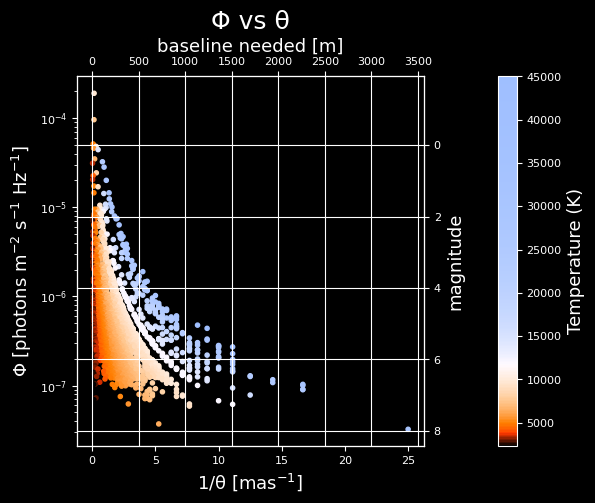

In [10]:
# Plot using the colormap based on temperatures
fig, ax1 = plt.subplots()

# Plot the first dataset with the colormap based on temperatures
sc = ax1.scatter(inverse_diameter, Phi_V, c=temps, cmap=bb_cmap, marker='.')
cbar = plt.colorbar(sc, ax=ax1, label='Temperature (K)', pad=0.15)
ax1.set_yscale('log')
ax1.set_xlabel('1/θ [mas$^{-1}$]')
ax1.set_ylabel(r'Φ [photons m$^{-2}$ s$^{-1}$ Hz$^{-1}$]')
ax1.set_title('Φ vs θ')
#ax1.set_xlim(0, 25)

ax2 = ax1.twinx()
ax3 = ax1.twiny()

# Set the limits for the second y-axis based on the transformation
phi_min, phi_max = ax1.get_ylim()
thetainverse_min, thetainverse_max = ax1.get_xlim()
if thetainverse_min < 0:
    thetainverse_min = 0

ax2.set_ylim(mag_from_phi(phi_min), mag_from_phi(phi_max))
ax2.set_ylabel('magnitude')

ax3.scatter(baselines_needed, Phi_V, c=temps, cmap=bb_cmap, marker='')
ax3.set_xlabel('baseline needed [m]')

ax2.grid(True)
ax3.grid(True)

print("Total number of stars taken into account:", len(Phi_V))
print(dist[7])


In [11]:
baselines_needed_array = np.array(baselines_needed)
indices_baseline = np.argwhere(baselines_needed_array < 80)

baselines_needed_ = baselines_needed_array[indices_baseline]
Vmag_ = Vmag[indices_baseline]
Phi_V_ = Phi_V[indices_baseline]
diameter_V_ = diameter_V[indices_baseline]
temps_ = temps[indices_baseline]
inverse_diameter_ = inverse_diameter[indices_baseline]
dist_ = dist[indices_baseline]

In [12]:
indices_magnitude = np.argwhere(Vmag_ < 3)

baselines_needed__ = baselines_needed_[indices_magnitude]
Phi_V__= Phi_V_[indices_magnitude]
diameter_V__ = diameter_V_[indices_magnitude]
temps__ = temps_[indices_magnitude]
inverse_diameter__ = inverse_diameter_[indices_magnitude]
dist__ = dist_[indices_magnitude]
Vmag__ = Vmag_[indices_magnitude]

Total number of stars taken into account: 71


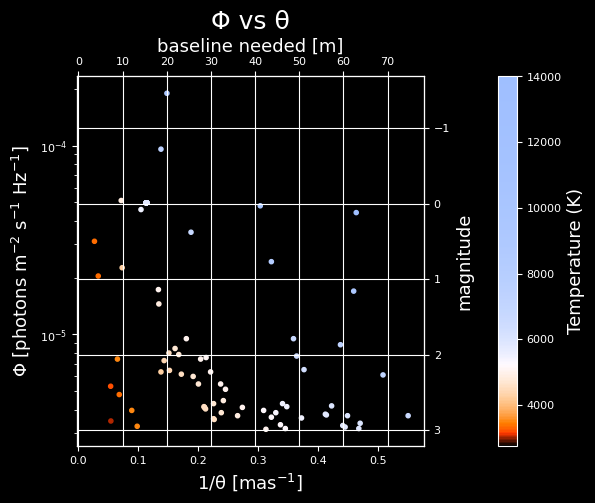

In [21]:
# Plot using the colormap based on temperatures
fig, ax1 = plt.subplots()

# Plot the first dataset with the colormap based on temperatures
sc = ax1.scatter(inverse_diameter__, Phi_V__, c=temps__, cmap=bb_cmap, marker='.')
cbar = plt.colorbar(sc, ax=ax1, label='Temperature (K)', pad=0.15)
ax1.set_yscale('log')
ax1.set_xlabel('1/θ [mas$^{-1}$]')
ax1.set_ylabel(r'Φ [photons m$^{-2}$ s$^{-1}$ Hz$^{-1}$]')
ax1.set_title('Φ vs θ')
#ax1.set_xlim(0, 25)

ax2 = ax1.twinx()
ax3 = ax1.twiny()

# Set the limits for the second y-axis based on the transformation
phi_min, phi_max = ax1.get_ylim()
thetainverse_min, thetainverse_max = ax1.get_xlim()
if thetainverse_min < 0:
    thetainverse_min = 0

ax2.set_ylim(mag_from_phi(phi_min), mag_from_phi(phi_max))
ax2.set_ylabel('magnitude')

ax3.scatter(baselines_needed__, Phi_V__, c=temps__, cmap=bb_cmap, marker='')
ax3.set_xlabel('baseline needed [m]')

ax2.grid(True)
ax3.grid(True)

print("Total number of stars taken into account:", len(Phi_V__))

In [14]:
def relmag_to_absmag(rel_magnitude, distance): #distance in parsec
    return rel_magnitude + 5 - 5 * np.log10(distance)

absmag_ = relmag_to_absmag(1.14, 10)

def luminosity(absmag):
    return 10**(0.4*(4.74 - absmag))

luminosity_ = luminosity(absmag_)
print(absmag_, luminosity_)

1.1399999999999997 27.54228703338169


In [15]:
luminosities = []
abs_Vmag = []

for i in range(len(Vmag__)):
    abs_Vmag.append(relmag_to_absmag(Vmag__[i], dist__[i]))
    
for i in range(len(Vmag__)):
    luminosities.append(luminosity(abs_Vmag[i]))

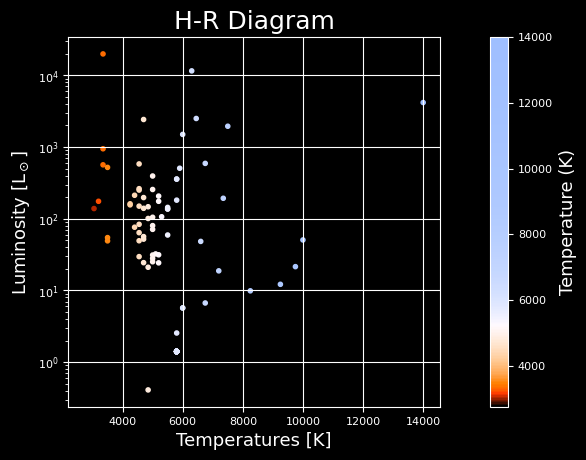

In [25]:
fig, ax1 = plt.subplots()
sc = ax1.scatter(temps__, luminosities, c=temps__, cmap=bb_cmap, marker='.')

# Set labels
ax1.set_ylabel(r'Luminosity [L$_\odot$]')
ax1.set_xlabel('Temperatures [K]')
ax1.set_title('H-R Diagram')
cbar = plt.colorbar(sc, ax=ax1, label='Temperature (K)', pad=0.1)
ax1.set_yscale('log')
ax1.grid(True)

In [ ]:
def diameter_in_solar_radii(diameter_mas, distance): #distance in parsec
    # Constants
    solar_radius_km = 696340  # 1 solar radius in kilometers
    
    # Convert distance from parsecs to kilometers
    distance_km = distance
    
    # Convert diameter from milliarcseconds to radians
    diameter_radians = (diameter_mas * 1e-3 * pi) / (648000)
    
    # Calculate the physical diameter in kilometers
    physical_diameter_km = diameter_radians * distance_km
    
    # Convert physical diameter to solar radii
    diameter_solar_radii = physical_diameter_km / solar_radius_km
    
    return diameter_solar_radii